In [1]:
from captcha.image import ImageCaptcha
from matplotlib import pyplot as plt
import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
import tensorflow as tf
import pickle
%matplotlib inline


In [9]:
#image = ImageCaptcha(fonts=['./font/AntykwaBold.ttf', './font/Candice.ttf', './font/VeraMono.ttf', './font/verdana.ttf'])

# %%timeit
# X = []
# for i in range(1000):
#     text = ''.join(random.sample(char_map, 4))
#     img = np.array(image.generate_image(text).resize((100, 40)))
#     img_gray = np.mean(img, -1)
#     if not isinstance(X, np.ndarray):
#         X = img_gray[..., np.newaxis]
#     else:
#         X = np.concatenate((X, img_gray[..., np.newaxis]), axis=-1)
#     #灰度值求解
#     #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
#     if i % 100 == 0:
#         print("generating captcha " , i)

width_images = 100
height_images = 40
num_charmap = 36
num_channel = 1
num_char = 4
char_map = string.ascii_uppercase + string.digits

def img_preprocess(img):
    img_resize = np.array(img.resize((width_images, height_images)))
#     img_gray = np.mean(img_resize, -1)
    img_gray = np.dot(img_resize, [0.2989, 0.5870, 0.1140])
    img_scale = np.multiply(img_gray, 1/255.0)
    img_func = np.vectorize(lambda x: x if (x<0.7) else 1)
    return img_func(img_scale)
#     return img_scale

def dataset_generator(num_images):
#     image_generator = ImageCaptcha(fonts=['./font/AntykwaBold.ttf'])
    image_generator = ImageCaptcha(width=100, height=40, fonts=['./font/LucidaGrande.ttf'], font_sizes=[38])
    X = np.zeros((num_images, height_images, width_images))
    y = np.zeros((num_images, num_charmap*num_char))
    for i in range(num_images):
        text = ''.join(random.sample(char_map, num_char))
        img = image_generator.generate_image(text)
        X[i, :, :] = img_preprocess(img)
        y_index = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
        y[i, y_index] = 1
#         if (i+1) % (num_images/5) == 0:
#             print("generating captcha " , i)
    return X, y
        #灰度值求解
        #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
    
def get_next_batch(X, y, batch_size=100):
    index_in_epoch = 0
    num_images = X.shape[0]
#     assert num_images <= X.shape[0]
    while True:
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_images:
            perm = np.arange(num_images)
            np.random.shuffle(perm)
            X = X[perm]
            y = y[perm]
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_images
        end = index_in_epoch
        yield X[start:end], y[start:end]     

# print("generate train dataset: \n", '-'*40)
# X_train, y_train = dataset_generator(num_images_train)
# print("generate test dataset: \n", '-'*40)
# X_test, y_test = dataset_generator(num_images_test)
# y_test = np.reshape(y_test, [-1, num_char, num_charmap])   
 

# dataset_dir = "./captcha_data/"
# dataset_name = "captcha.pickle"
# dataset_path = os.path.join(dataset_dir, dataset_name)
# if os.path.exists(dataset_path):
#     with open(dataset_path, 'rb') as f:
#         X_train = pickle.load(f)
#         y_train = pickle.load(f)
#         y_test = pickle.load(f)
#         X_test = pickle.load(f)
# else:
#     if not os.path.isdir(dataset_dir):
#         os.mkdir(dataset_dir)
#     print("generate train dataset: \n", '-'*40)
#     X_train, y_train = dataset_generator(num_images_train)
#     print("generate test dataset: \n", '-'*40)
#     X_test, y_test = dataset_generator(num_images_test)
#     y_test = np.reshape(y_test, [-1, num_char, num_charmap])
#     if num_images_train <= 60000:
#         with open(dataset_path, 'wb') as f:
#             pickle.dump(X_train, f)
#             pickle.dump(y_train, f)
#             pickle.dump(y_test, f)
#             pickle.dump(X_test, f)



In [3]:
# def weight_variable(shape):
#     initial = tf.truncated_normal(shape, stddev=0.1)
#     return tf.Variable(initial)

# def bias_variable(shape):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.Variable(initial)

# def conv2d(x, W):
#     return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# def max_pool_2x2(x):
#     return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# # with tf.device('/gpu:0'):
# x = tf.placeholder(tf.float32, [None, height_images, width_images])
# y_ = tf.placeholder(tf.float32, [None, num_char, num_charmap])

# #todo: find out why reshape doesn.t work
# x_image = tf.reshape(x, [-1, height_images, width_images, 1])
# # y_ = tf.reshape(y_, [-1, num_char, num_charmap])

# #Dropout
# keep_prob = tf.placeholder(tf.float32)


# #First Convolutional Layer
# W_conv1 = weight_variable([5, 5, 1, 32])
# b_conv1 = bias_variable([32])
# h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
# h_pool1 = max_pool_2x2(h_conv1)

# #Second Convolutional Layer
# W_conv2 = weight_variable([5, 5, 32, 64])
# b_conv2 = bias_variable([64])
# h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool2 = max_pool_2x2(h_conv2)

# #Third Convolutional Layer
# # W_conv3 = weight_variable([5, 5, 64, 128])
# # b_conv3 = bias_variable([128])
# # h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# # h_pool3 = max_pool_2x2(h_conv2)

# #First densely Connected Layer
# W_fc1 = weight_variable([10 * 25 * 64, 1024])
# b_fc1 = bias_variable([1024])
# h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# #Readout Layer
# W_fc2 = weight_variable([1024, 144])
# b_fc2 = bias_variable([144])

# y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# #cross_entropy_1 无法导向正确结果，废弃
# #cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
# #分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数


# y_conv = tf.reshape(y_conv, [-1, num_char, num_charmap])

# cross_entropy = tf.reduce_mean(tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(y_conv[:, _i ,:], y_[:, _i,:]) 
#                   for _i in range(num_char) ]))

# # cross_entropy = tf.reduce_mean(
# #     tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
# #         y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
# #                   for i in range(num_char) ]))
# train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
# max_idx_p = tf.argmax(y_conv, 2)
# max_idx_l = tf.argmax(y_, 2)
# correct_prediction = tf.cast(tf.equal(max_idx_p, max_idx_l), tf.float32)
# accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=1))

#drop out after conv layer
#在两个convnet后都添加dropout层，3W次迭代无法收敛（误，无法收敛或许为batch_size有关）

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, height_images, width_images])
y_ = tf.placeholder(tf.float32, [None, num_char,  num_charmap])

#todo: find out why reshape doesn.t work
x_image = tf.reshape(x, [-1, height_images, width_images, 1])
# y_ = tf.reshape(y_, [-1, num_char, num_charmap])

#Dropout
keep_prob = tf.placeholder(tf.float32)


#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_conv2_drop = tf.nn.dropout(h_conv2, keep_prob)
h_pool2 = max_pool_2x2(h_conv2)
# h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)

#Third Convolutional Layer
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool3 = max_pool_2x2(h_conv2)

#First densely Connected Layer
W_fc1 = weight_variable([10 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 144])
b_fc2 = bias_variable([144])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#cross_entropy_1 无法导向正确结果，废弃
#cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
#分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数


y_conv = tf.reshape(y_conv, [-1, num_char, num_charmap])

cross_entropy = tf.reduce_mean(tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
                y_conv[:, _i, :], y_[:, _i, :]) for _i in range(num_char) ]))

# cross_entropy = tf.reduce_mean(
#     tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
#         y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
#                   for i in range(num_char) ]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
max_idx_p = tf.argmax(y_conv, 2)
max_idx_l = tf.argmax(y_, 2)
correct_prediction = tf.cast(tf.equal(max_idx_p, max_idx_l), tf.float32)
accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=1))

saver = tf.train.Saver()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [ ]:
#training

sess = tf.InteractiveSession(config=config)
# with tf.Session(config=config) as sess:
sess.run(tf.global_variables_initializer())

#batch_size 小会导致多次迭代仍无法收敛
#h_fc1_drop：one batch 64:100; 128:200; 256:800
#h_fc1_drop：all batches 64:++; 128:8000; 256:6900
#h_fc1_drop, h_conv2_drop: one batch 64:700; 128:800; 256:1200
#h_fc1_drop, h_conv2_drop: all batches 64:++; 128:++; 256:++
#每当训练准确率达到90%，更换训练集，直到测试准确率达到80%
#1W-0.028; 3W-0.269

num_images_train = 20000
num_images_test = 1000
test_accuracy = 0.0
epoch = 0
while True:
    saver.restore(sess, "./model/model.ckpt")
#     sess.run(tf.global_variables_initializer())
    print("generate train dataset: \n", '-'*40)
    X_train, y_train = dataset_generator(num_images_train)
    print("generate test dataset: \n", '-'*40)
    X_test, y_test = dataset_generator(num_images_test)
    y_test = y_test.reshape(-1, num_char, num_charmap)
    #变化的batch_size训练更快
    batch_size= 64*(epoch+1)
    train_batch = get_next_batch(X_train, y_train, batch_size)
    step = 0
    # X_batch, y_batch = next(train_batch)
    # y_batch = y_batch.reshape(-1, num_char, num_charmap)
    test_accuracy = accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})
    print(time.ctime() ,"epoch %d,test accuracy %g"%(epoch, test_accuracy))
    print("* "*40)
    while True:
        X_batch, y_batch = next(train_batch)
        y_batch = y_batch.reshape(-1, num_char, num_charmap)
        if (step+1)%500 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
            print(time.ctime() ,": step %d, training accuracy %g"%(step, train_accuracy))
            #过拟合，训练准确率不能超过 95%
            #train_ac - test_ac > 0.08
            if train_accuracy >= 0.95:
                test_accuracy = accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})
                print(time.ctime() ,"epoch %d,test accuracy %g"%(epoch, test_accuracy))
                print("* "*40)
                saver.save(sess, "./model/model.ckpt")
                break
        step += 1
        sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})
    if test_accuracy >= 0.88 or batch_size >= 512:
        print(time.ctime() ,"training done!test accuracy is %g"%test_accuracy)
        break
    epoch += 1
    
#  无法收敛的元凶:batch_size
#     train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

In [16]:
#training 2

sess = tf.InteractiveSession(config=config)
# with tf.Session(config=config) as sess:
sess.run(tf.global_variables_initializer())

#batch_size 小会导致多次迭代仍无法收敛
#h_fc1_drop：one batch 64:100; 128:200; 256:800
#h_fc1_drop：all batches 64:++; 128:8000; 256:6900
#h_fc1_drop, h_conv2_drop: one batch 64:700; 128:800; 256:1200
#h_fc1_drop, h_conv2_drop: all batches 64:++; 128:++; 256:++
#每当训练准确率达到90%，更换训练集，直到测试准确率达到80%
#1W-0.028; 3W-0.269

num_train_batch = 128
num_images_test = 512
test_accuracy = 0.0
step = 0
# sess.run(tf.global_variables_initializer())
saver.restore(sess, "./model/model.ckpt")
while True:
#     sess.run(tf.global_variables_initializer())
    X_train, y_train = dataset_generator(num_train_batch)
    #变化的batch_size训练更快
    # X_batch, y_batch = next(train_batch)
    # y_batch = y_batch.reshape(-1, num_char, num_charmap)
#     print(time.ctime() ,"epoch %d,test accuracy %g"%(epoch, test_accuracy))
    X_batch = X_train
    y_batch = y_train.reshape(-1, num_char, num_charmap)
    if (step)%100 == 0:
        X_test, y_test = dataset_generator(num_images_test)
        y_test = y_test.reshape(-1, num_char, num_charmap)
        test_accuracy = accuracy.eval(feed_dict={x: X_test, y_: y_test, keep_prob: 1.0})
#         train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, test accuracy %g"%(step, test_accuracy))
        #过拟合，训练准确率不能超过 95%
        #train_ac - test_ac > 0.08
        if test_accuracy >= 0.92:
            print("trainning cnn done, total setps: ", step)
            saver.save(sess, "./model/model.ckpt")
            break
    step += 1
    sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

    
#  无法收敛的元凶:batch_size
#     train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

Mon Jan 16 22:58:23 2017 : step 0, test accuracy 0.925781
trainning cnn done, total setps:  0


In [9]:
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
saver.restore(sess, "./model/model.ckpt")
# print("generate test dataset: \n", '-'*40)
from captcha.image import ImageCaptcha
image_generator = ImageCaptcha(width=100, height=40, fonts=['./font/LucidaGrande.ttf'], font_sizes=[38])
X_test, y_test = dataset_generator(200)
y_test = y_test.reshape(-1, num_char, num_charmap)
X, y = X_test, y_test
pred = max_idx_p.eval(feed_dict={x:X, keep_prob: 1.0})
print("test accuracy: ",accuracy.eval(feed_dict={x: X, y_: y, keep_prob: 1.0}))

test accuracy:  0.925


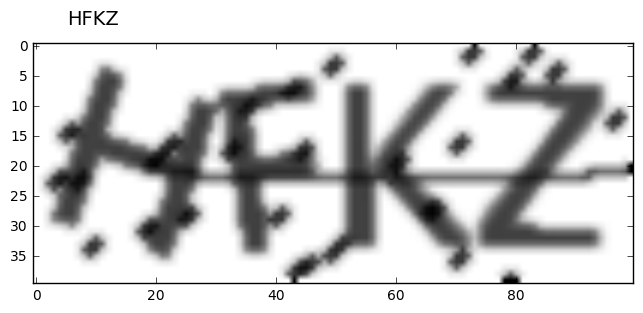

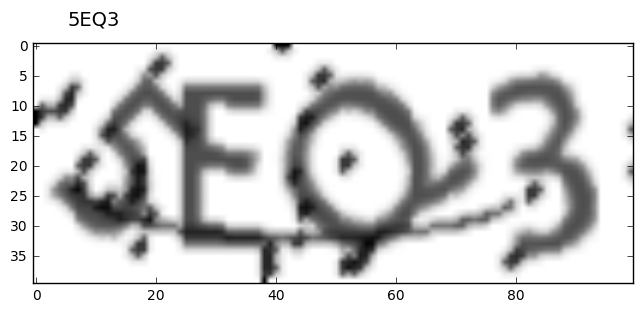

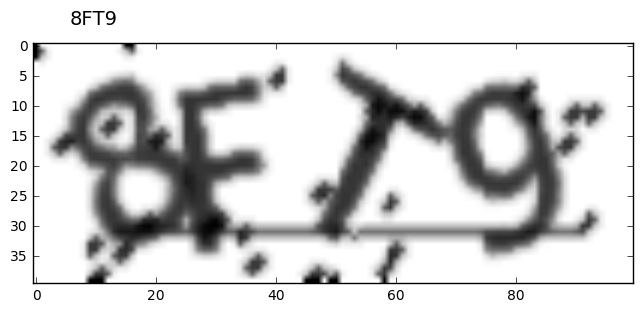

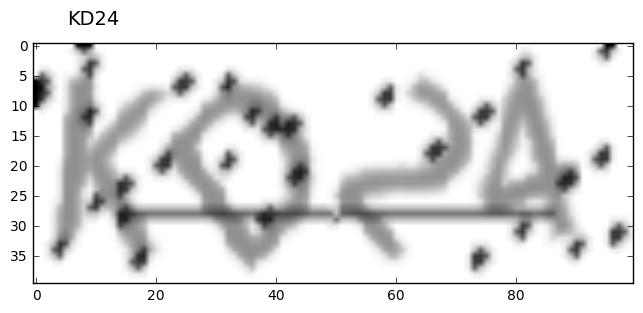

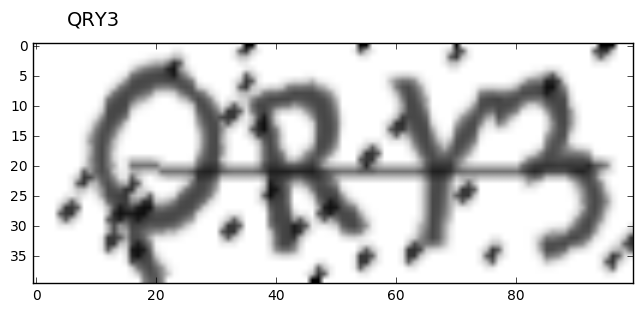

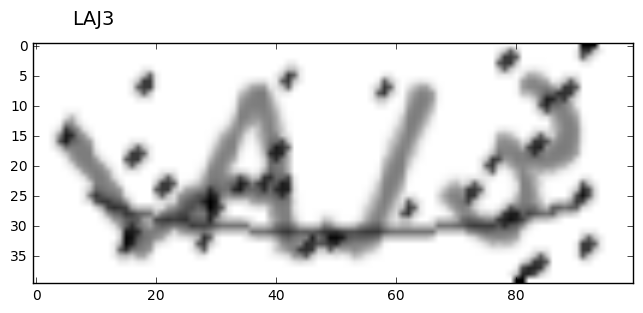

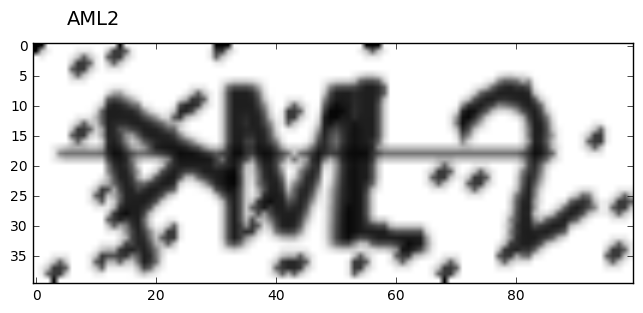

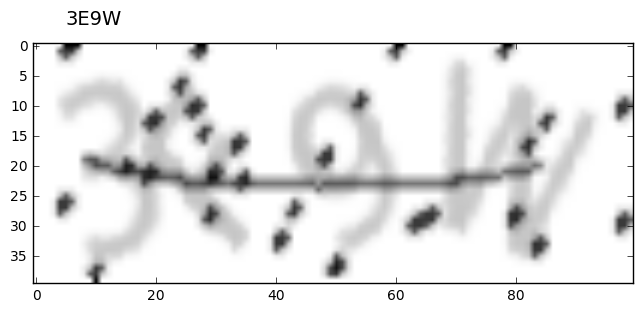

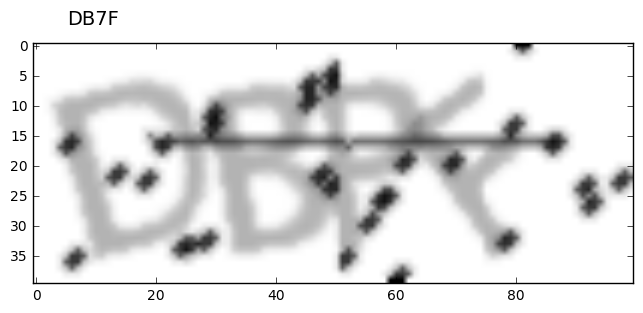

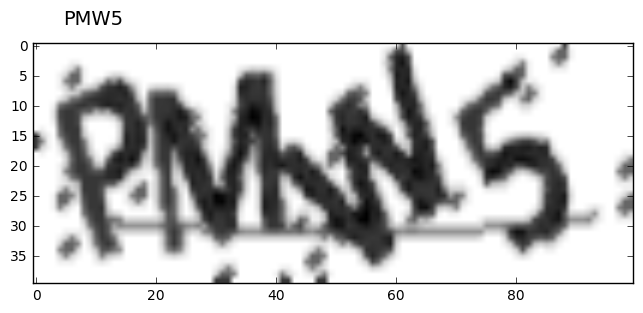

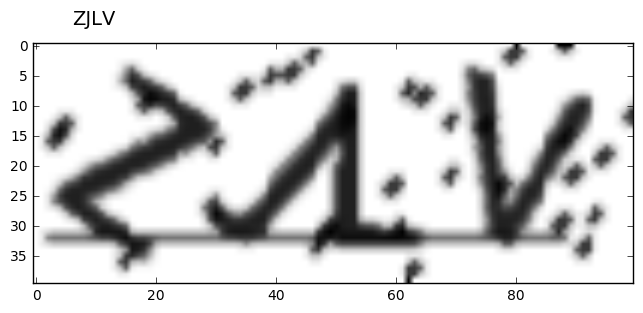

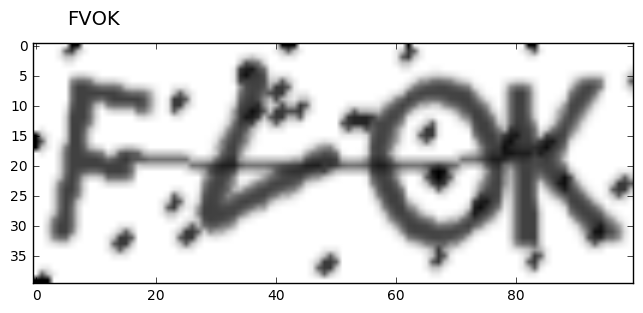

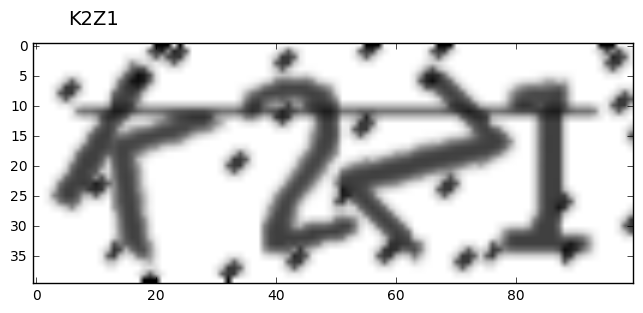

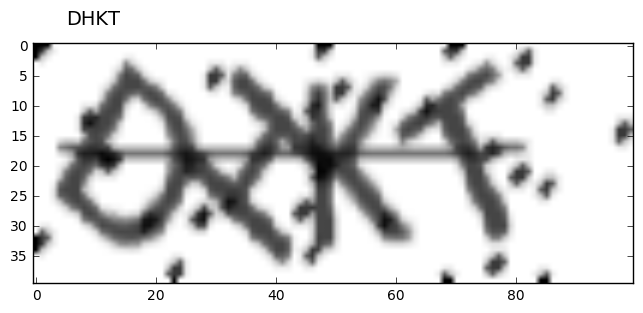

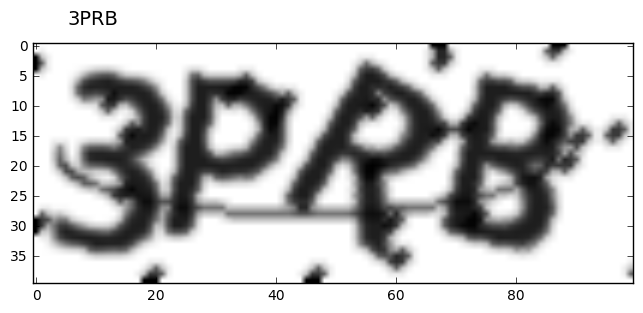

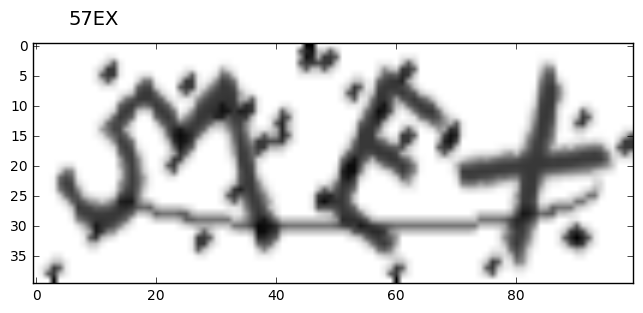

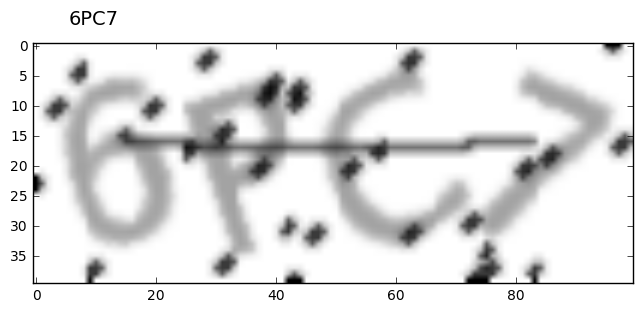

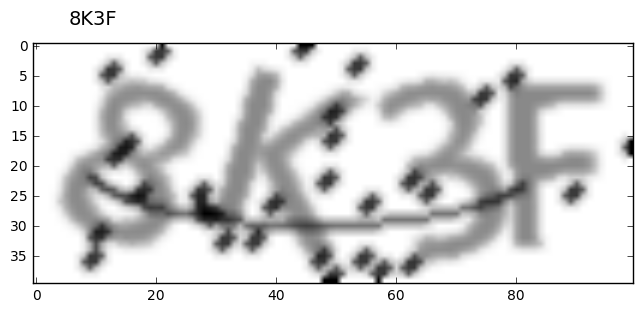

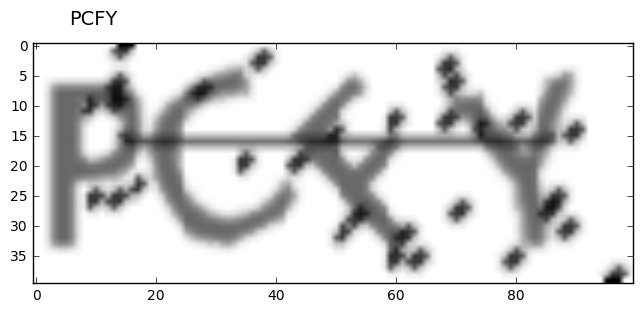

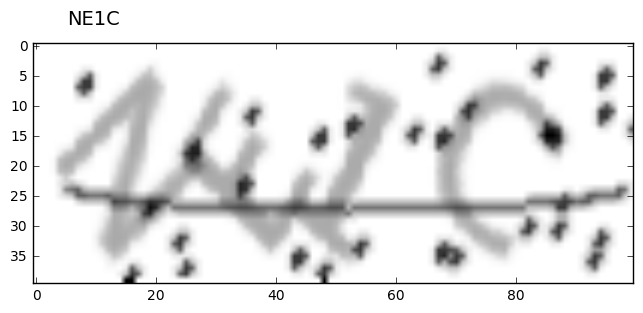

In [10]:
# with tf.Session(config=config) as sess:
# saver = tf.train.Saver()
# config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allow_growth = True
# sess = tf.InteractiveSession(config=config)
# sess.run(tf.global_variables_initializer())
# saver.restore(sess, "./model/model.ckpt")
plot_ind = 50
idx_lst = range(plot_ind, plot_ind+20)
for idx in idx_lst:
#     print(''.join([char_map[_i] for _i in pred[idx]]))
    text = ''.join([char_map[_i] for _i in pred[idx]])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.text(0.1, 1.1, text, ha='center', va='center', fontsize=14, transform=ax.transAxes)
    plt.imshow(X[idx].reshape((height_images, width_images)), cmap='gray')

In [117]:
def train_set_ge():
    for _i in range(1, 6, 1):
        folder = 'part' + str(_i)
        imgpath = './captcha_train/captcha1/' + folder + '/*.jpg'
        train_data_lst =  glob.glob(imgpath)
        batch_size = 20000
        X_train = np.zeros((batch_size, height_images, width_images))
        y_train = np.zeros((batch_size, num_charmap*num_char))
        _indx = 0
        for _img in train_data_lst:
            img = Image.open(_img)
            img_scale = img_preprocess(img)
            X_train[_indx, :, :] = img_scale
            text = _img.split('\\')[-1].split('#')[-1].split('.')[0]
            y_indx = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
            y_train[_indx, y_indx] = 1
            _indx += 1
        yield X_train, y_train

In [118]:
t_g = train_set_ge()
X, y = next(t_g)

In [121]:
#training 3

sess = tf.InteractiveSession(config=config)
# with tf.Session(config=config) as sess:
sess.run(tf.global_variables_initializer())

#batch_size 小会导致多次迭代仍无法收敛
#h_fc1_drop：one batch 64:100; 128:200; 256:800
#h_fc1_drop：all batches 64:++; 128:8000; 256:6900
#h_fc1_drop, h_conv2_drop: one batch 64:700; 128:800; 256:1200
#h_fc1_drop, h_conv2_drop: all batches 64:++; 128:++; 256:++
#每当训练准确率达到90%，更换训练集，直到测试准确率达到80%
#1W-0.028; 3W-0.269

num_images_train = 20000
epoch = 0
t_g = train_set_ge()
saver.restore(sess, "./model/model.ckpt")
while True:
    X_train, y_train = next(t_g)
    #变化的batch_size训练更快
    batch_size= 64*(epoch+1)
    train_batch = get_next_batch(X_train, y_train, batch_size)
    step = 0
    while True:
        X_batch, y_batch = next(train_batch)
        y_batch = y_batch.reshape(-1, num_char, num_charmap)
        if (step+1)%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
            print(time.ctime() ,": step %d, training accuracy %g"%(step, train_accuracy))
            if train_accuracy >= 0.90:
                break
        step += 1
        sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})
    epoch += 1
saver.save(sess, "./model/model.ckpt")

Tue Jan 17 22:15:47 2017 : step 499, training accuracy 0.921875
Tue Jan 17 22:17:15 2017 : step 499, training accuracy 0.96875
Tue Jan 17 22:20:32 2017 : step 499, training accuracy 0.979167
Tue Jan 17 22:24:09 2017 : step 499, training accuracy 0.992188
Tue Jan 17 22:28:05 2017 : step 499, training accuracy 0.99375


StopIteration: 

In [124]:
saver.save(sess, "./model/model.ckpt")

'./model/model.ckpt'

In [122]:
itable_lst =  glob.glob('./captcha/*')
X_itable = np.empty((len(itable_lst), height_images, width_images))
_ind = 0
img_func = np.vectorize(lambda x: x if (x<0.7) else 1)
for img_name in itable_lst:
    img = Image.open(img_name)
    img_scale = img_preprocess(img)
    X_itable[_ind, :, :] = img_scale
    _ind += 1
# saver = tf.train.Saver()
# config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allow_growth = True
# sess = tf.InteractiveSession(config=config)
# saver.restore(sess, "./model/model.ckpt")
X = X_itable
pred = max_idx_p.eval(feed_dict={x:X, keep_prob: 1.0})


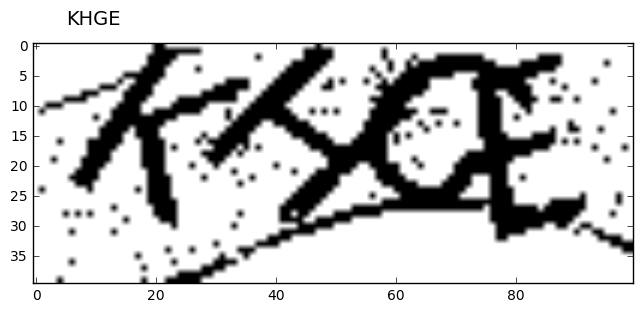

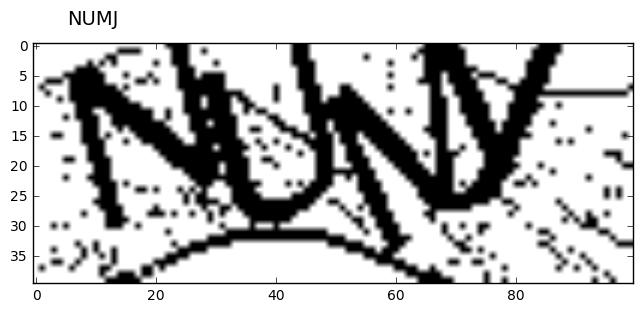

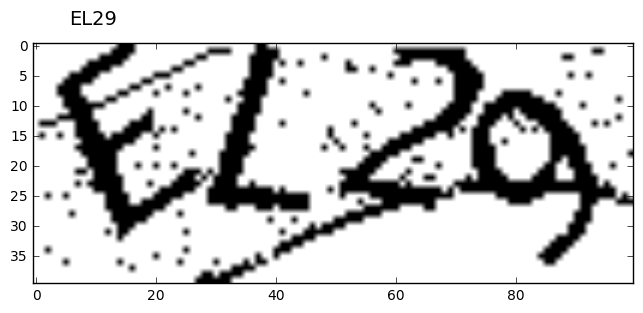

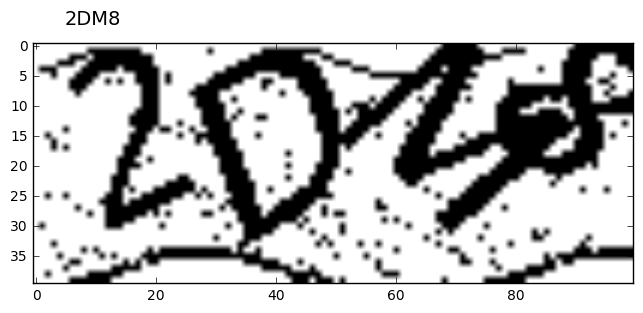

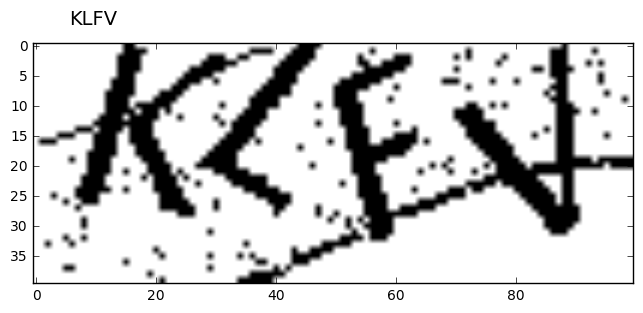

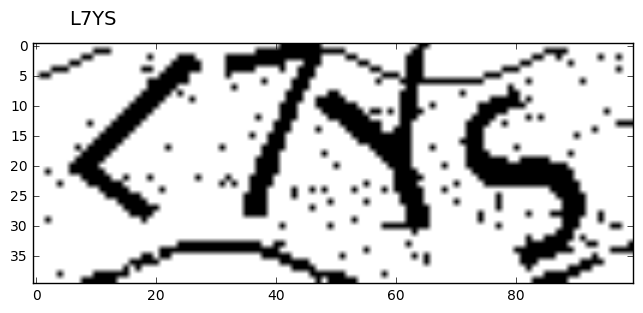

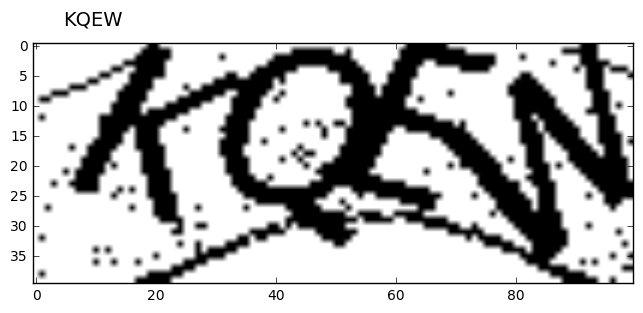

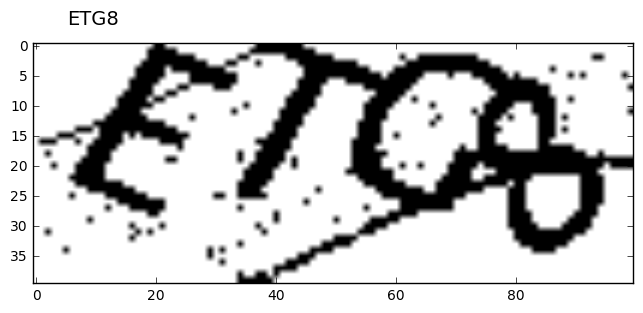

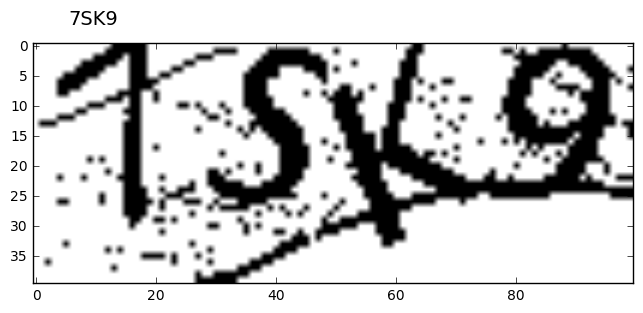

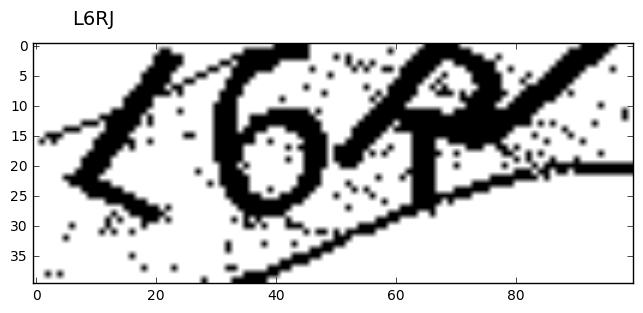

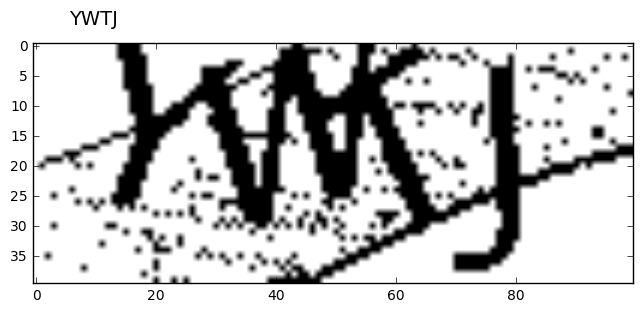

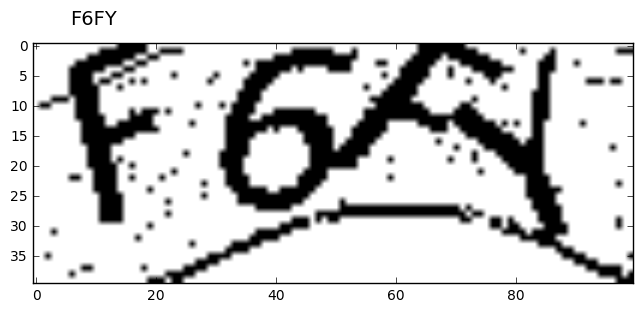

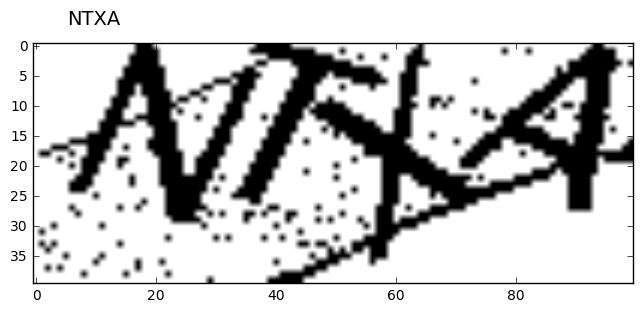

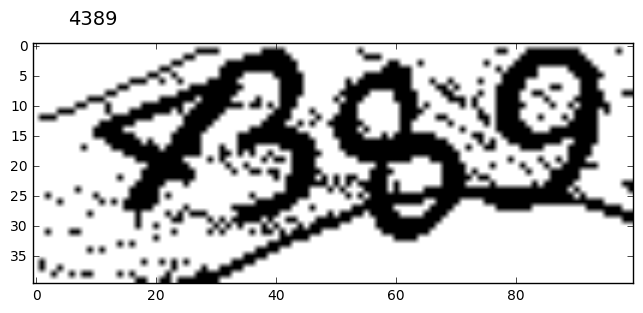

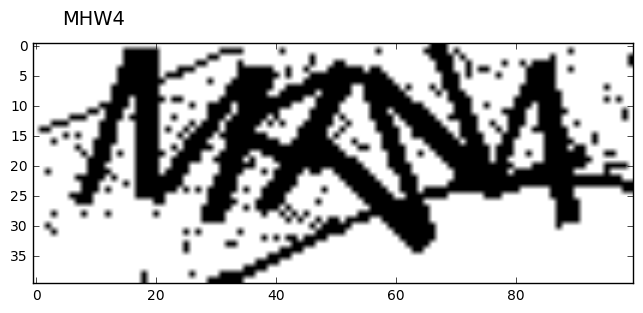

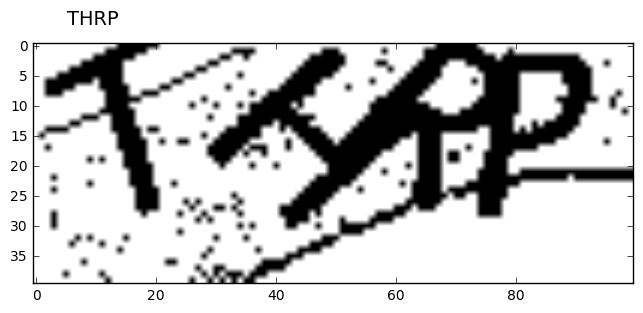

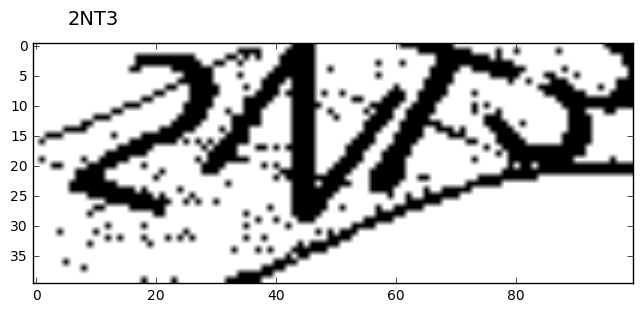

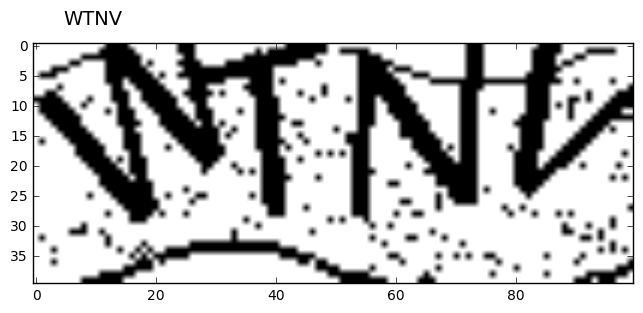

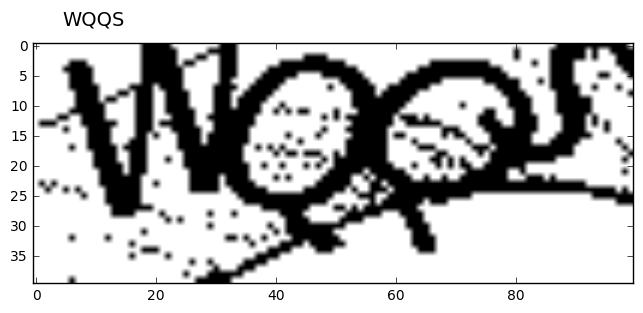

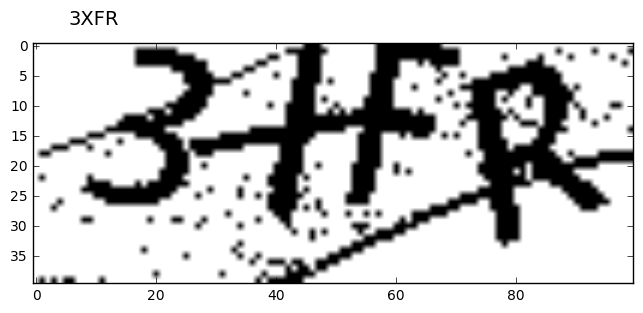

In [123]:
plot_ind = 80
idx_lst = range(plot_ind, plot_ind+20)
for idx in idx_lst:
#     print(''.join([char_map[_i] for _i in pred[idx]]))
    text = ''.join([char_map[_i] for _i in pred[idx]])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.text(0.1, 1.1, text, ha='center', va='center', fontsize=14, transform=ax.transAxes)
    plt.imshow(X[idx].reshape((height_images, width_images)), cmap='gray')
    

In [ ]:
itable_lst =  glob.glob('./captcha/*')
X_itable = np.empty((len(itable_lst), height_images, width_images))
_ind = 0
for img_name in itable_lst:
    if _ind < 10:
        img = Image.open(img_name)
        plt.figure()
        plt.imshow(img, cmap="gray")
    _ind += 1
    

In [126]:
for idx in range(len(X_itable)):
    text = ''.join([char_map[_i] for _i in pred[idx]])
    plt.imsave('./captcha_train/pred/'+str(idx)+'_'+text+'.jpg', X_itable[idx], cmap='gray')

In [ ]:
y_ind

In [ ]:
X_test, y_test = dataset_generator(10)
y_test = y_test.reshape(-1, num_char, num_charmap)
y_ind = np.argmax(y_test, axis=2)
text = [''.join([char_map[_i] for _i in _ind]) for _ind in y_ind]
print(text)
for i in range(10):
    plt.imsave('./img/'+str(i)+'.jpg', X_test[i], cmap='gray')

In [ ]:
random.uniform(-45, 45)

In [ ]:
from captcha.image import ImageCaptcha

image_generator = ImageCaptcha(width=100, height=40, fonts=['./font/LucidaGrande.ttf'], font_sizes=[38])
for i in range(20):
    text = ''.join(random.sample(char_map, num_char))
    img = (image_generator.generate_image(text))
    fig = plt.figure()
#     ax = fig.add_axes([0,0,1,1])
#     ax.text(0.1, 1.1, text, ha='center', va='center', fontsize=14, transform=ax.transAxes)
    plt.imshow(img, cmap='gray')

In [20]:
next(t_ge)

TypeError: 'module' object is not callable

In [ ]:
Draw

In [ ]:
from PIL.ImageDraw import Draw

In [ ]:
char_map.find('6')

In [ ]:
im = Image.new('RGB', (100, 40))

In [ ]:
im.rotate()